In [1]:
# this notebook aims to rewrite our model in terms of Q, Qs, A
# we will then test three basic scenarios
# this will be done through the building and testing of three functions
# function 1: basic stream power
# function 2: bed transport with downstream mass loss; single lithology (grains and bed composed of same material)
# function 3: bed transport with downstream mass loss; two lithologies (grains harder than bed)

# but first, just a quick run to see if the model can be stable when starting with zero H thickness

#### Steps to writing the model in terms of Q

1. Anywhere $q$, or $q_s$, appears in the model should be replaced with $\frac{Q}{W}$, $\frac{Q_s}{W}$
2. This means that we first need to calculate $W$
> from Wickert and Schildgen 2019: $W = \frac{k_b Q S^{7/6}}{D^{3/2}}$

>> kind of weird that $Q$ cancels and width depends only on slope and grain size, but I guess that's the point?

>> so, anywhere that $q$ appears, we can just sub in $\frac{D^{3/2}}{k_b S^{7/6}}$

>> maybe the best way to do this is to include a line in our main loop, right after calculating slope, that is $q = \frac{D^{3/2}}{k_b S^{7/6}}$

3. We're starting with the simplest case, so not even worrying about sediment effects or $Q_s$ yet. Just praying this works first.

> when we do get to the point of thinking about sediment, we'll replace all instances of $q_s = cqS$ with $q_s = \frac{c D^{3/2}}{k_b S^{1/6}}$

>> this is what you get when you simplify $q_s = \frac{Q_s}{W}$, where $Q_s = cQs$

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# set up basic stuff

# grid
dx_1 = 1000
x_1 = np.arange(0, 100000, dx_1)

# elevation
# thoughts:
# need to start with some slope, otherwise width will be zero and will wind up with divide by zero errors
# done
eta_1 = np.zeros(len(x_1))
# eta_1[:] = np.linspace(10, 0.1, len(x_1))

# set reasonable runoff rate in m/yr, see Rossi et al 2016 supplemental
# commented out because we don't need this if Q cancels out 
# (don't need any coeffecients that go into translating A into Q)
# r_1 = np.zeros(len(x_1))
# r_1[:] = 0.3

# erodibility for soft rock
k_sed_1 = np.zeros(len(x_1))
k_sed_1[:] = 0.000000001

# grainsize
D_1 = 0.2
D_2 = 0.3

In [4]:
# now make the first function: pure stream power
# take out adaptive timstep stuff, only add it back in if it seems necessary

def stream_power(x,
                 dx,
                 eta,
                 k_sed,
                 D, # gravel
                 c = 1, # should be 0.041, from W & S '19 (assuming constant geomorphically effective flow)
                 baselevel_rate = 0.001, # uplifting 1 mm/yr
                 num_steps = 500):
    
    eta[:] = np.linspace(1, 0.1, len(x))
    
    kb = 8.3e-8 # wickert and schildgen width coefficient (2.61) converted to have time units of years
    kh = 0.3
    r = 0.3
    
    W = np.zeros(len(x))
    W[0] = 0
    
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    bedrock_ero[-1] = baselevel_rate
    
    Q = r * kh * x**2
    q = np.zeros(len(x))
    q[0] = 0
    
    dt = (0.2 * dx * dx / (c*Q[-1])) # "global" time-step size # mult by 0.2
    
    for i in range(num_steps):

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        # calc width
        W[1:] = (kb * Q[1:] * (np.abs(S)**(7/6))) / (D**(3/2))
        
        # calc q
        q[1:] = (D**(3/2)) / (kb * ((np.abs(S)**(7/6))))
        
        #  calc bedrock erosion rate from stream power (plucking)
        bedrock_ero[:-1] = k_sed[1:] * q[1:] * S
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  calc change in bedrock elev
        eta[:-1] -= bedrock_ero[:-1] * dt
        
        if any(bedrock_ero[:] != baselevel_rate):
            continue
        else:
            break
            
        
    return (S, W, q, bedrock_ero, eta)

In [ ]:
# # now create an input experiment
# stream_power_1 = [x_1, dx_1, eta_1, k_sed_1, D_1, 1, 0.01, 200]

# # run experiment and catch outputs!
# (slope_SP_1,
#  width_SP_1,
#  unit_discharge_SP_1,
#  bedrock_erosion_rate_SP_1,
#  topography_SP_1) = stream_power(*stream_power_1)

In [5]:
# now create an input experiment
stream_power_2 = [x_1, dx_1, eta_1, k_sed_1, D_1, 1, 0.01, 600000]

# run experiment and catch outputs!
(slope_SP_2,
 width_SP_2,
 unit_discharge_SP_2,
 bedrock_erosion_rate_SP_2,
 topography_SP_2) = stream_power(*stream_power_2)

Okay, these erosion rates are indicating that the moedl isn't updating properly. We can confirm this by checking out the topography, too.

In [6]:
# topography_SP_1 - topography_SP_2

In [7]:
# topography_SP_1

In [8]:
topography_SP_2

array([-0.01256247, -0.02903187, -0.02903038, -0.04550546, -0.04549837,
       -0.06196295, -0.06196631, -0.07843789, -0.07843425, -0.09490155,
       -0.09490229, -0.11137461, -0.11137035, -0.12783896, -0.12783854,
       -0.14431303, -0.14430691, -0.16077226, -0.16077573, -0.17724054,
       -0.17724471, -0.19370927, -0.19371656, -0.21018132, -0.21018738,
       -0.22666217, -0.22666396, -0.24315149, -0.24315208, -0.25962756,
       -0.25962565, -0.2761382 , -0.27614585, -0.29275169, -0.29275482,
       -0.30900987, -0.30900839, -0.32589625, -0.32590189, -0.34453185,
       -0.34454113, -0.35374445, -0.3537512 , -0.39155077, -0.39155466,
       -0.39155658, -0.3915523 , -0.40014453, -0.40014853, -0.4501498 ,
       -0.45014839, -0.45015935, -0.45015711, -0.47747713, -0.47749368,
       -0.47749137, -0.47748772, -0.47749518, -0.47749708, -0.47749979,
       -0.47750059, -0.47750121, -0.47749582, -0.47749911, -0.47750017,
       -0.47749299, -0.47749787, -0.47748864, -0.47749021, -0.47

In [9]:
# bedrock_erosion_rate_SP_1

In [10]:
# plt.plot(x_1, topography_SP_1)

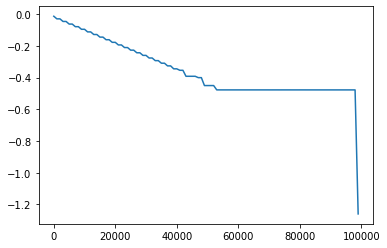

In [11]:
plt.plot(x_1, topography_SP_2)

In [ ]:
plt.plot(x_1[1:], slope_SP_1)

Yup, basically no change from the initial condition, despite the model supposedly running for 50,000 steps.

In [ ]:
# now see if I can get a copied and pasted version of the two lithology model working

# SET UP GRID ARRAYS
dx_2 = 1000
x_2 = np.arange(0, 100000, dx_2)

# set up references to topography
Hstar_2 = 0.1
H_2 = Hstar_2 + np.zeros(len(x_2))

etab_2 = np.zeros(len(x_2))
etab_2[:] = np.linspace(1000, 0.1, len(x_2))

eta_2 = etab_2 + H_2

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_2 = np.zeros(len(x_2))
beta_ig_2[:25] = 0.00004
beta_sed_2 = np.zeros(len(x_2))
beta_sed_2[25:] = 0.00014
atr_factor_2 = 0.00004

# erodibility values
k_ig_2 = np.zeros(len(x_2))
k_ig_2[:25] = 0.0001
k_sed_2 = np.zeros(len(x_2))
k_sed_2[25:] = 0.001

In [ ]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     D,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    kb = 8.3e-8 # 2.61 # wickert and schildgen width coefficient
    kh = 0.3
    r = 0.3
    W = np.zeros(len(x))
    W[0] = 0
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    
    Q = r * kh * x**2
    q = np.zeros(len(x))
    q[0] = 0
    
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * (0.2 * dx * dx / (c*Q[-1]))  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        # calc width
        W[1:] = (kb * Q[1:] * S**(7/6)) / (D**(3/2))
        
        # calc q
        q[1:] = (D**(3/2)) / (kb * (S**(7/6)))
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = ((c * D**(3/2)) / (kb * (S**(1/6)))) * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, W, q, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, 
            atr, sedimentation_rate, H, total_ero, cum_time)

In [ ]:
# create the input experiment
two_lith_20cm = [x_2, dx_2, Hstar_2, H_2, etab_2, eta_2, beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, D_1]

# and run away with it!
(slope_TL_20,
 width_TL_20,
 unit_discharge_TL_20,
 unit_sed_flux_TL_20,
 e_factor_TL_20,
 topography_TL_20,
 bedrock_elevation_TL_20,
 igneous_plucking_rate_TL_20,
 sedimentary_plucking_rate_TL_20,
 igneous_abrasion_rate_TL_20,
 sedimentary_abrasion_rate_TL_20,
 bedrock_erosion_rate_TL_20,
 attrition_rate_TL_20,
 sedimentation_rate_TL_20,
 sediment_thickness_TL_20,
 total_erosion_rate_TL_20,
 cum_time_TL_20) = two_lith_one_sed(*two_lith_20cm)

In [ ]:
# okay, no error messages at least...
# check to see if we're at steady state
print(bedrock_erosion_rate_TL_20)

But there seems to be this same issue of the model not updating.

In [ ]:
plt.plot(x_2, topography_TL_20)

Yup. 

In [ ]:
# finally, set up a single lithology model by simply using same (soft rock) values for all abrasion
# and erodibility parameters

# SET UP GRID ARRAYS
dx_3 = 1000
x_3 = np.arange(0, 100000, dx_3)

# set up references to topography
Hstar_3 = 0.1
H_3 = Hstar_3 + np.zeros(len(x_3))

etab_3 = np.zeros(len(x_3))
etab_3[:] = np.linspace(1000, 0.1, len(x_3))

eta_3 = etab_3 + H_3

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_sed_3 = np.zeros(len(x_3))
beta_sed_3[:] = 0.00014
atr_factor_3 = 0.00014

# erodibility values
k_sed_3 = np.zeros(len(x_3))
k_sed_3[:] = 0.001

In [ ]:
# just seeing if we can consolidate the above function into something more sensible for single lithology

# write a function that has one bedrock lithologies in the domain, but only one contributing sediment to bedload
def one_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_sed,
                     atr_factor,
                     k_sed,
                     D,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 1000000, 
                     porosity = 0.55):
    
    
    kb = 8.3e-8 # 2.61 # wickert and schildgen width coefficient
    kh = 0.3
    r = 0.3
    W = np.zeros(len(x))
    W[0] = 0
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    
    Q = r * kh * x**2
    q = np.zeros(len(x))
    q[0] = 0
    
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * dx * dx / (c*Q[-1])  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        # calc width
        W[1:] = (kb * Q[1:] * S**(7/6)) / (D**(3/2))
        
        # calc q
        q[1:] = (D**(3/2)) / (kb * (S**(7/6)))
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = ((c * D**(3/2)) / (kb * (S**(1/6)))) * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_sed + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_sed))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (S, W, q, qs, efac, eta, etab, ero_plucking_sed, ero_ab_sed, bedrock_ero, atr, sedimentation_rate, H, 
            total_ero, cum_time)

In [ ]:
# create the input experiment
one_lith_20cm = [x_3, dx_3, Hstar_3, H_3, etab_3, eta_3, beta_sed_3, atr_factor_3, k_sed_3, D_1]

# and run away with it!
(slope_OL_20,
 width_OL_20,
 unit_discharge_OL_20,
 sed_flux_OL_20,
 e_factor_OL_20,
 topography_OL_20,
 bedrock_elevation_OL_20,
 sedimentary_plucking_rate_OL_20,
 sedimentary_abrasion_rate_OL_20,
 bedrock_erosion_rate_OL_20,
 attrition_rate_OL_20,
 sedimentation_rate_OL_20,
 sediment_thickness_OL_20,
 total_erosion_rate_OL_20,
 cum_time_OL_20) = one_lith_one_sed(*one_lith_20cm)

In [ ]:
# okay, that worked!
# check to see if we're at steady state
print(bedrock_erosion_rate_OL)

In [ ]:
plt.plot(x_3, topography_OL)

# neato

In [ ]:
# now make some slope area plots in log-log space

area = x_1**2

plt.plot(area[1:], slope_SP, label = 'stream power')
plt.plot(area[1:], slope_TL, label = 'two lithologies')
plt.plot(area[1:], slope_OL, label = 'single lithology')
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Some reminders:

<img align = "left" src="concavity_steepness.png" width=325 height=325 />
<img align = "right" src="profile_SA_plots.png" width=625 height=625 />

#### okay, some initial thoughts and observations:

- is a "linear" (in log-log space) slope-area relationship only expected when erodibility is constant? That would make sense and explains why "two lithologies" plots this way.
> Yes, from Lague 2014 - everything about Flint's law and the predicted relationship between steepness index and concavity is formed on the assumption of uniform lithology, bedrock-incising, "DTL" rivers.


- both the OL and TL runs looks like "Type 2" from Lague's figure above, meaning slope decreases downstream. This means that concavity is INCREASING! Even though the profile looks "planed off" and "flattened," think of it as having moved further away from a convex or linear profile.

- The really important thing to notice in the TL case is that slopes are higher near the lithologic contact, and then take a dive; this is why the "two lithology" case has the overall highest concavity (see below)
> this kind of makes sense: presence of abrasion clasts = higher concavity in softer substrate

- but what's up with the single lithology case? The fact that the line has some curvature to it means that concavity is not constant; the steeper slope of the line as area increases means slope shallows downstream, i.e., increasing concavity. However, the single lithology case is still overall steeper (in lower reaches) than the stream power case (see below).
> NOTE: not sure I understand how single lithology case can be <i><b>steeper</b></i> than stream power case, but have <i><b>lower total concavity</b></i>?

>> EDIT: I think I get this. I can easily imagine a river with a very high but completely linear (unchanging, constant) slope. That would be high steepness but low concavity. Concavity is a measure of the rate of change of slope, while steepness is more about the magnitude of the slope. The single lithology case is seeing some effects of sediment cover, which lowers the concavity. 

> and what accounts for the higher steepness? Something about modeling the effects of abrasion increases steepness in downstream reaches even if the sediment isn't any "harder" than the substrate it flows over. Is the difference in steepness between downstream reaches in SP vs OL model basically just the sediment abrasion effect? Representing the portion of steepness that SP models are unable to capture/would tend to under-predict?

In [ ]:
plt.plot(area[26:], slope_SP[25:], label = 'stream power')
plt.plot(area[26:], slope_TL[25:], label = 'two lithologies')
plt.plot(area[26:], slope_OL[25:], label = 'single lithology')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area (m^2)')
plt.ylabel('slope')
plt.legend()

In [ ]:
# slope, intercept = np.polyfit(np.log(length), np.log(time), 1)
slope_1, intercept_1 = np.polyfit(np.log(area[1:]), np.log(slope_SP), 1)
slope_2, intercept_2 = np.polyfit(np.log(area[1:]), np.log(slope_TL), 1)
slope_3, intercept_2 = np.polyfit(np.log(area[1:]), np.log(slope_OL), 1)

# concavity is -slope
concavity_SP = -slope_1
concavity_TL = -slope_2
concavity_OL = -slope_3

print("Stream power downstream ss concavity: ", concavity_SP)
print("Two lithology downstream ss concavity: ", concavity_TL)
print("One lithology downstream ss concavity: ", concavity_OL)

In [ ]:
# neato.
# now design 3 quick runs to see if steepness increases with increasing uplift rate (as expected)
# so just change baselevel rate from 0.001 to 0.003

# now create an input experiment
stream_power_high_U = [x_1, dx_1, eta_1, k_sed_1, r_1, 1, 0.002]

# run experiment and catch outputs!
(discharge_SP_high_U,
 slope_SP_high_U,
 bedrock_erosion_rate_SP_high_U,
 topography_SP_high_U,
 i_SP_high_U) = stream_power(*stream_power_high_U)

In [ ]:
# create the input experiment
TL_high_U = [x_2, dx_2, Hstar_2, H_2, etab_2, eta_2, beta_ig_2, beta_sed_2, atr_factor_2, k_ig_2, k_sed_2, r_2, 1, 0.002, 5000000]

# and run away with it!
(slope_TL_high_U,
 sed_flux_TL_high_U,
 e_factor_TL_high_U,
 topography_TL_high_U,
 bedrock_elevation_TL_high_U,
 igneous_plucking_rate_TL_high_U,
 sedimentary_plucking_rate_TL_high_U,
 igneous_abrasion_rate_TL_high_U,
 sedimentary_abrasion_rate_TL_high_U,
 bedrock_erosion_rate_TL_high_U,
 attrition_rate_TL_high_U,
 sedimentation_rate_TL_high_U,
 sediment_thickness_TL_high_U,
 total_erosion_rate_TL_high_U,
 cum_time_TL_high_U) = two_lith_one_sed(*TL_high_U)

In [ ]:
# create the input experiment
OL_high_U = [x_3, dx_3, Hstar_3, H_3, etab_3, eta_3, beta_sed_3, atr_factor_3, k_sed_3, r_3, 1, 0.002]

# and run away with it!
(slope_OL_high_U,
 sed_flux_OL_high_U,
 e_factor_OL_high_U,
 topography_OL_high_U,
 bedrock_elevation_OL_high_U,
 sedimentary_plucking_rate_OL_high_U,
 sedimentary_abrasion_rate_OL_high_U,
 bedrock_erosion_rate_OL_high_U,
 attrition_rate_OL_high_U,
 sedimentation_rate_OL_high_U,
 sediment_thickness_OL_high_U,
 total_erosion_rate_OL_high_U,
 cum_time_OL_high_U) = one_lith_one_sed(*OL_high_U)

In [ ]:
fig, ax = plt.subplots(3, figsize = (10, 14))

ax[0].plot(area[26:], slope_SP[25:], label = 'low uplift')
ax[0].plot(area[26:], slope_SP_high_U[25:], label = 'high uplift')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_title('stream power')

ax[1].plot(area[26:], slope_TL[25:], label = 'low uplift')
ax[1].plot(area[26:], slope_TL_high_U[25:], label = 'high uplift')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title('two lithologies')

ax[2].plot(area[26:], slope_OL[25:], label = 'low uplift')
ax[2].plot(area[26:], slope_OL_high_U[25:], label = 'high uplift')
ax[2].legend()
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_title('one lithology')

In [ ]:
# okay, we are now ready to move onto The Big Kahoona
# streamwise width variation

# if we assume a uniform grain size, the only difference in the three runs sould be slope
# so, the widht results should basically be a reflection of slope variation

# start be defining total discharge in terms of area
# this should be the same for each run, since its three dependencies are the same throughout

# Q = runoff x factor accounting for basin geometry x area as distance squared

# runoff is already defined above for each run, using names `r_1`, `r_2`, etc.
# area is already defined above
k_discharge = 0.3 # related to drainage basin geometry

Q = r_1 * k_discharge * area

# verified on paper that units work out and k_b = 2.61 is correct
# k_b has dimensions [T]/[L^1/2]

k_b = 2.61
D = 0.02 # grain size of 20 mm

width_SP = (k_b * Q[1:] * (slope_SP**1.17)) / (D**1.5)
width_TL = (k_b * Q[1:] * (slope_TL**1.17)) / (D**1.5)
width_OL = (k_b * Q[1:] * (slope_OL**1.17)) / (D**1.5)

width_SP_high_U = (k_b * Q[1:] * (slope_SP_high_U**1.17)) / (D**1.5)
width_TL_high_U = (k_b * Q[1:] * (slope_TL_high_U**1.17)) / (D**1.5)
width_OL_high_U = (k_b * Q[1:] * (slope_OL_high_U**1.17)) / (D**1.5)

plt.plot(x_1[1:], width_SP, label = 'stream power', color = 'b')
plt.plot(x_2[1:], width_TL, label = 'two lithologies', color = 'orange')
plt.plot(x_3[1:], width_OL, label = 'one lithology', color = 'g')
plt.plot(x_1[1:], width_SP_high_U, color = 'b', linestyle = '--')
plt.plot(x_2[1:], width_TL_high_U, color = 'orange', linestyle = '--')
plt.plot(x_3[1:], width_OL_high_U, color = 'g', linestyle = '--')
plt.legend()
plt.title('streamwise width, uniform grainsize')

In [ ]:
# make 3 subplots, showing:
# 1. ss topography for all 3 cases, slow and fast uplift
# 2. slope-area for all 3 cases, slow and fast uplift
# 3. width for all 3 cases, slow and fast uplift

In [ ]:
# print(total_erosion_rate_TL_high_U) # so tL isn't at steady state # now call it close enough
# print(total_erosion_rate_OL_high_U)
# print(bedrock_erosion_rate_SP_high_U)

In [ ]:
fig, ax = plt.subplots(3, figsize = (10, 14))

# ax[0].plot(x_1, topography_SP, label = 'stream power', color = 'b')
# ax[0].plot(x_2, topography_TL, label = 'two lithologies', color = 'orange')
# ax[0].plot(x_3, topography_OL, label = 'one lithology', color = 'g')
# ax[0].plot(x_1, topography_SP_high_U, color = 'b', linestyle = '--')
# ax[0].plot(x_2, topography_TL_high_U, color = 'orange', linestyle = '--')
# ax[0].plot(x_3, topography_OL_high_U, color = 'g', linestyle = '--')
# ax[0].legend()
# ax[0].set_title('steady state topography')



ax[2].plot(x_1[1:], width_SP, label = 'stream power', color = 'b')
ax[2].plot(x_2[1:], width_TL, label = 'two lithologies', color = 'orange')
ax[2].plot(x_3[1:], width_OL, label = 'one lithology', color = 'g')
ax[2].plot(x_1[1:], width_SP_high_U, color = 'b', linestyle = '--')
ax[2].plot(x_2[1:], width_TL_high_U, color = 'orange', linestyle = '--')
ax[2].plot(x_3[1:], width_OL_high_U, color = 'g', linestyle = '--')
ax[2].legend()
ax[2].set_title('streamwise width, uniform grainsize')